# ASHRAE - Great Energy Predictor III

Assessing the value of energy efficiency improvements can be challenging as there's no way to truly know how much energy a building would have used without the improvements. The best we can do is to build counterfactual models. Once a building is overhauled the new (lower) energy consumption is compared against modeled values for the original building to calculate the savings from the retrofit. More accurate models could support better market incentives and enable lower cost financing.

This competition challenges you to build these counterfactual models across four energy types based on historic usage rates and observed weather. The dataset includes three years of hourly meter readings from over one thousand buildings at several different sites around the world.

## 项目简单分析

- 项目简单描述：通过对各种能源（冷水、电、天然气、热水和蒸汽表）消耗的预测达到节约能源的目的（未采取措施 vs 采取措施），数据来源于1000栋建筑3年的数据；
- 预测单位：单栋建筑的各项能源消耗；
- 是否时间序列：是；
- 数据量级：三年×1000栋建筑；
- 特点：未采取措施的建筑能源消耗 vs 采取措施的建筑能源消耗；
- 评估函数：RMSLE(Root Mean Squared Logarithmic Error)；
- TIMELINE：2019年12月12日；

## 库导入

In [1]:
import os,sys,math,gc

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

%matplotlib inline

sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

## 数据加载

- weather.csv:各个site每小时的天气信息，7M；
- building.csv:每个建筑的元信息, 40+K；
- train.csv:每个建筑每小时的读数信息，600+M；
- 测试文件大于训练文件；

In [2]:
PATH = '/home/kael/Data/ashrae-energy-prediction/'

In [3]:
!ls -allh /home/kael/Data/ashrae-energy-prediction

total 2.5G
drwxrwxr-x 2 kael kael 4.0K 10月 20 12:22 .
drwxrwxr-x 3 kael kael 4.0K 10月 20 12:22 ..
-rw-rw-r-- 1 kael kael  45K 10月 10 17:20 building_metadata.csv
-rw-rw-r-- 1 kael kael 427M 10月 10 17:20 sample_submission.csv
-rw-rw-r-- 1 kael kael 1.4G 10月 10 17:20 test.csv
-rw-rw-r-- 1 kael kael 648M 10月 10 17:22 train.csv
-rw-rw-r-- 1 kael kael  15M 10月 10 17:23 weather_test.csv
-rw-rw-r-- 1 kael kael 7.2M 10月 10 17:23 weather_train.csv


In [4]:
# 这里会指定部分字段类型以减少内存占用，详细可以参考统计目录下的analysis.py和memory_reduce.py脚本
building_data = pd.read_csv(PATH+'building_metadata.csv', 
                            dtype={'site_id':'uint8','building_id':'uint16','primary_use':'category',
                                   'square_feet':'uint32','year_built':'float32','floor_count':'float32'})

weather_train_data = pd.read_csv(PATH+'weather_train.csv', 
                                 dtype={'site_id':'uint8','air_temperature':'float32','cloud_coverage':'float32',
                                        'dew_temperature':'float32','precip_depth_1_hr':'float32',
                                        'sea_level_pressure':'float32','wind_direction':'float32',
                                        'wind_speed':'float32'}, 
                                 parse_dates=['timestamp'], infer_datetime_format=True)

train_data = pd.read_csv(PATH+'train.csv', 
                         dtype={'building_id':'uint16','meter':'uint8','meter_reading':'float32'}, 
                         parse_dates=['timestamp'], infer_datetime_format=True)

In [5]:
all_train_data = train_data.merge(building_data, how='left').merge(weather_train_data, left_on=['site_id','timestamp'], right_on=['site_id','timestamp'])
del building_data, weather_train_data, train_data

In [6]:
all_train_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20125605 entries, 0 to 20125604
Data columns (total 16 columns):
building_id           uint16
meter                 uint8
timestamp             datetime64[ns]
meter_reading         float32
site_id               uint8
primary_use           category
square_feet           uint32
year_built            float32
floor_count           float32
air_temperature       float32
cloud_coverage        float32
dew_temperature       float32
precip_depth_1_hr     float32
sea_level_pressure    float32
wind_direction        float32
wind_speed            float32
dtypes: category(1), datetime64[ns](1), float32(10), uint16(1), uint32(1), uint8(2)
memory usage: 1.2 GB


In [7]:
all_train_data.sample(5)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
3230206,41,0,2016-03-02 02:00:00,0.000000,0,Office,93860,1968.0,NaN,18.900000,4.0,13.9,0.0,1019.200012,160.0,3.1
3540247,216,1,2016-03-08 06:00:00,207.106995,2,Education,137065,1964.0,NaN,14.400000,6.0,0.6,0.0,1004.500000,270.0,6.2
14723263,1418,0,2016-09-26 13:00:00,17.725000,15,Lodging/residential,41302,1975.0,NaN,12.200000,0.0,3.9,NaN,1019.400024,150.0,4.6
16927227,1436,0,2016-11-04 16:00:00,15.225000,15,Manufacturing/industrial,11302,1937.0,NaN,6.700000,NaN,1.7,NaN,1025.599976,320.0,5.7
15378650,1381,0,2016-10-08 03:00:00,55.674999,15,Office,84615,1963.0,NaN,17.799999,NaN,11.1,-1.0,1020.000000,170.0,4.1


## EDA

字段说明：
- train.csv:
  - building_id：建筑表的外键；
  - meter：资源代码{0: electricity, 1: chilledwater, 2: steam, 3: hotwater}，PS：不是所有建筑都有所有资源消耗的数据；
  - timestamp：读数时间；
  - meter_reading - 千瓦时的真实读数，注意这个是带有误差的真实数据；
  - test.csv：多一个row_id，少meter_reading；
  - 间隔是1小时；
- building_meta.csv：
  - site_id - 天气表的外键；.
  - building_id - 训练表的外键；
  - primary_use - 建筑主要活动、用途类别指标（离散型，应该有很大相关性）；
  - square_feet - 建筑总面积，不知道包不包含每层楼，如果包含，那么跟floor_count就有重复，如果不包含，可以考虑构建一个总面积的特征；
  - year_built - 建筑开始使用年份，越老越费电？？
  - floor_count - 楼层总数，预计线性关系；
- weather[train/test].csv（尽可能接近建筑的天气信息）：
  - site_id - 天气表外键；
  - air_temperature - 空气摄氏温度；
  - cloud_coverage - Portion of the sky covered in clouds, in oktas
  - dew_temperature - [露点温度](https://baike.baidu.com/item/%E9%9C%B2%E7%82%B9/1574011?fr=aladdin)摄氏度；
  - precip_depth_1_hr - Millimeters
  - sea_level_pressure - 海平面压力，Millibar/hectopascals；
  - wind_direction - 风向，0~360；
  - wind_speed - 风速，米每秒；
  - 间隔是1小时；

### 基本信息

In [8]:
print '='*50+'数值特征描述'+'='*50
print all_train_data.select_dtypes(include=['uint8','uint16','uint32','float32']).describe()
print ''
print '='*50+'时间特征描述'+'='*50
print all_train_data.select_dtypes(include=['datetime']).describe()
print ''
print '='*50+'类别特征描述'+'='*50
print all_train_data.select_dtypes(include=['category']).describe()
print ''

==================================================数值特征描述==================================================
        building_id         meter  meter_reading       site_id   square_feet  \
count  2.012560e+07  2.012560e+07   2.012560e+07  2.012560e+07  2.012560e+07   
mean   7.972116e+02  6.617305e-01   2.124811e+03  7.967773e+00  1.077848e+05   
std    4.263729e+02  9.310748e-01   1.535796e+05  5.092223e+00  1.171616e+05   
min    0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00  2.830000e+02   
25%    3.910000e+02  0.000000e+00   1.830000e+01  3.000000e+00  3.252700e+04   
50%    8.940000e+02  0.000000e+00   7.875000e+01  9.000000e+00  7.270900e+04   
75%    1.176000e+03  1.000000e+00   2.678430e+02  1.300000e+01  1.391130e+05   
max    1.448000e+03  3.000000e+00   2.190470e+07  1.500000e+01  8.750000e+05   

         year_built   floor_count  air_temperature  cloud_coverage  \
count  8.012299e+06  3.495553e+06     2.011944e+07    1.139074e+07   
mean   1.968349e+03  4.175366e+0

### 读数分析

1. 是否是累计的：不是累计的；
2. 会不会清空：每次读数都是独立的；

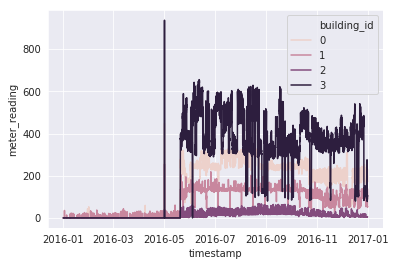

In [9]:
sns.lineplot(x="timestamp", y="meter_reading", hue="building_id", data=all_train_data[all_train_data.building_id<4][['timestamp','meter_reading','building_id']])

In [10]:
gc.collect()

167

### 连续字段相关性、分布情况分析

In [13]:
continuous_feature = ['square_feet','floor_count','air_temperature','cloud_coverage',
                      'dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction',
                     'wind_speed']

229

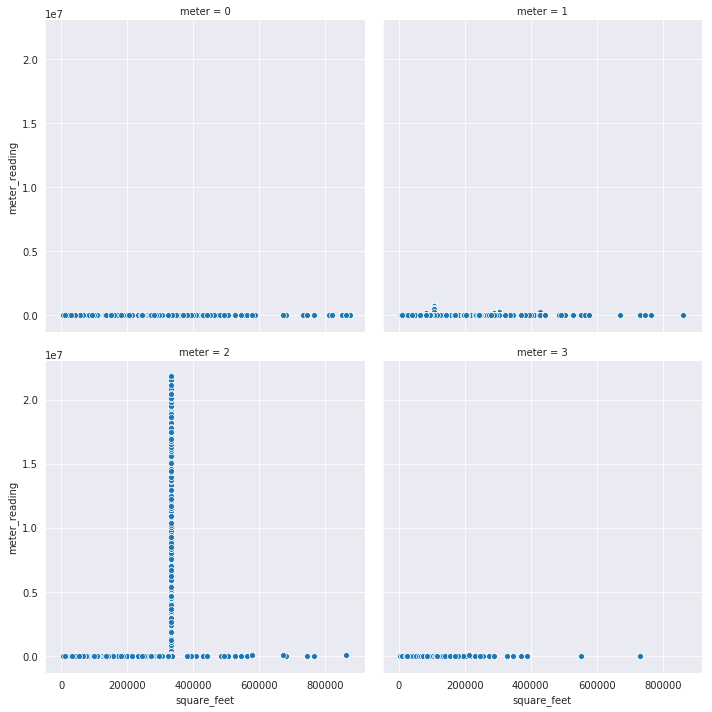

In [14]:
sns.relplot(x='square_feet', y="meter_reading", col="meter", col_wrap=2, data=all_train_data)
gc.collect()

15610

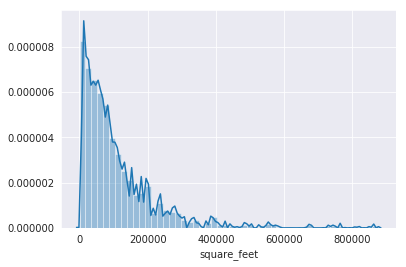

In [15]:
sns.distplot(all_train_data[np.isfinite(all_train_data.square_feet)]['square_feet'])
gc.collect()

354

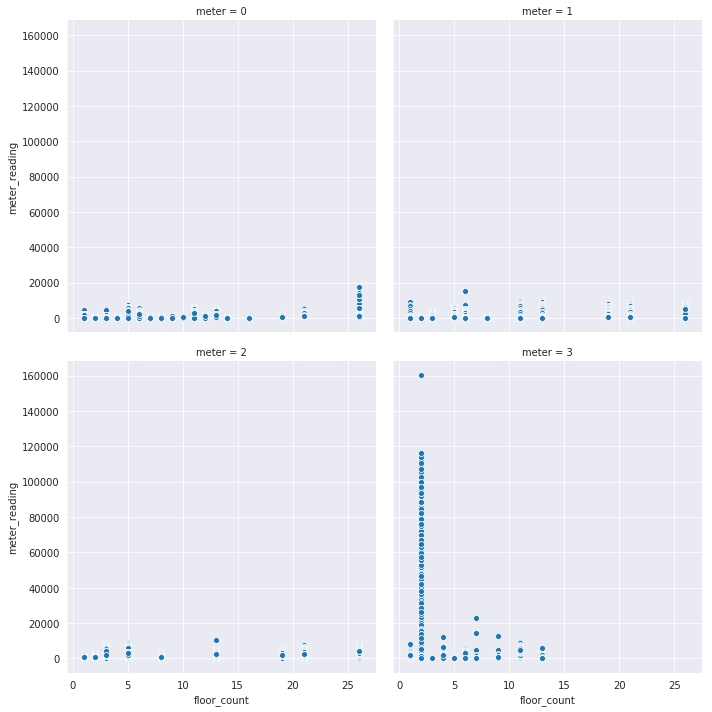

In [16]:
sns.relplot(x='floor_count', y="meter_reading", col="meter", col_wrap=2, data=all_train_data)
gc.collect()

17022

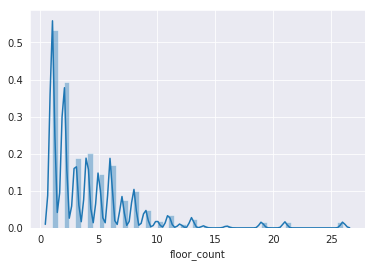

In [17]:
sns.distplot(all_train_data[np.isfinite(all_train_data.floor_count)]['floor_count'])
gc.collect()

206

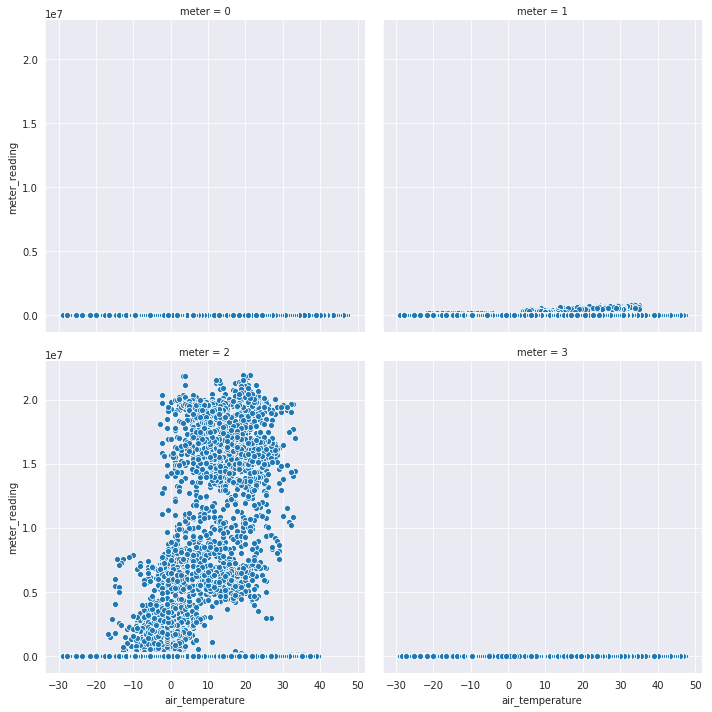

In [18]:
sns.relplot(x='air_temperature', y="meter_reading", col="meter", col_wrap=2, data=all_train_data)
gc.collect()

16970

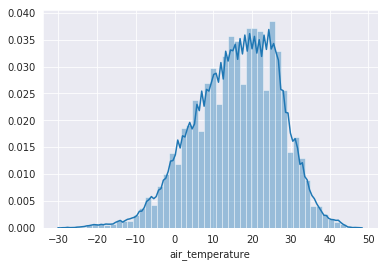

In [19]:
sns.distplot(all_train_data[np.isfinite(all_train_data.air_temperature)]['air_temperature'])
gc.collect()

229

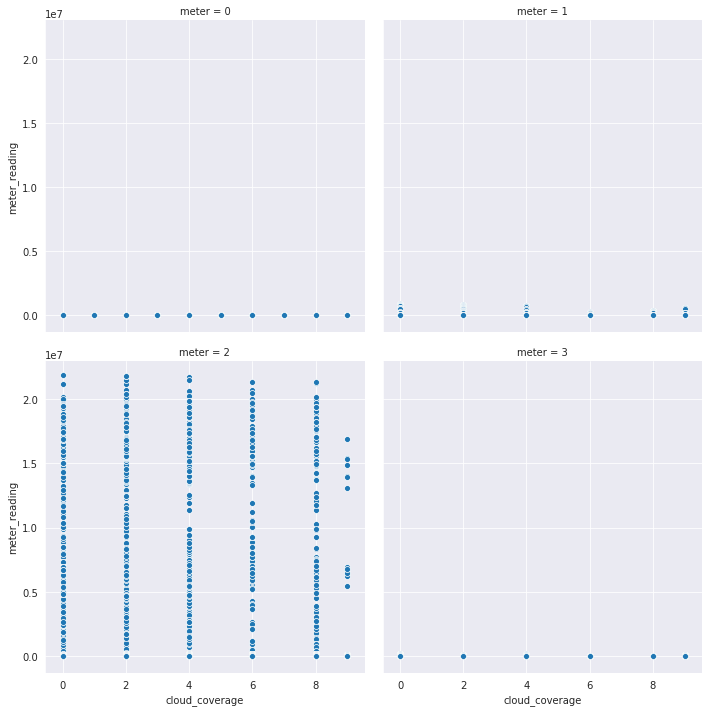

In [20]:
sns.relplot(x='cloud_coverage', y="meter_reading", col="meter", col_wrap=2, data=all_train_data)
gc.collect()

15466

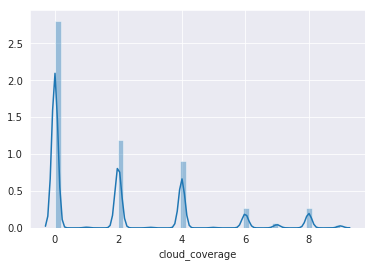

In [21]:
sns.distplot(all_train_data[np.isfinite(all_train_data.cloud_coverage)]['cloud_coverage'])
gc.collect()

391

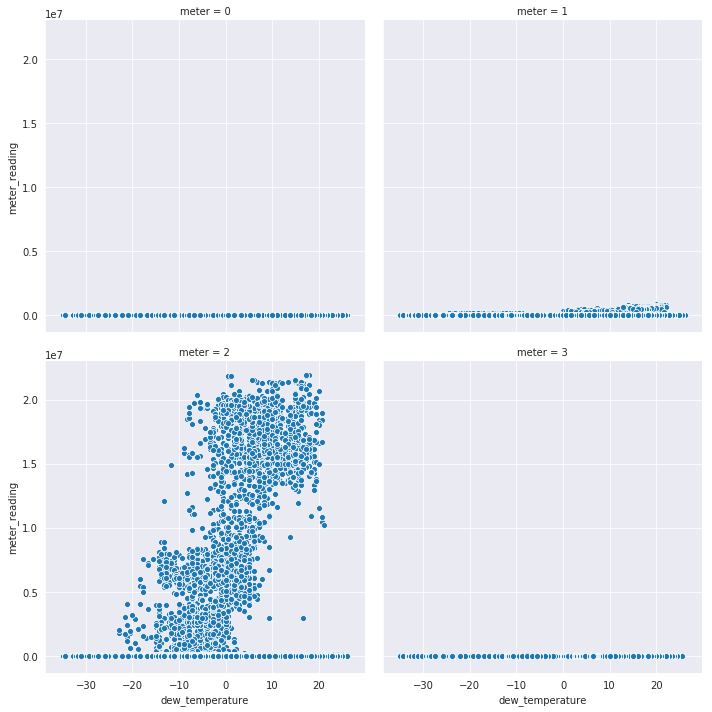

In [22]:
sns.relplot(x='dew_temperature', y="meter_reading", col="meter", col_wrap=2, data=all_train_data)
gc.collect()

15950

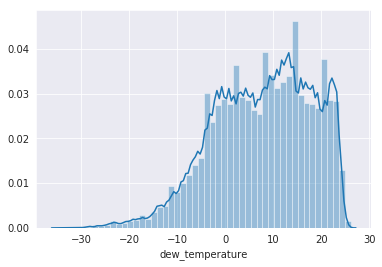

In [23]:
sns.distplot(all_train_data[np.isfinite(all_train_data.dew_temperature)]['dew_temperature'])
gc.collect()

539

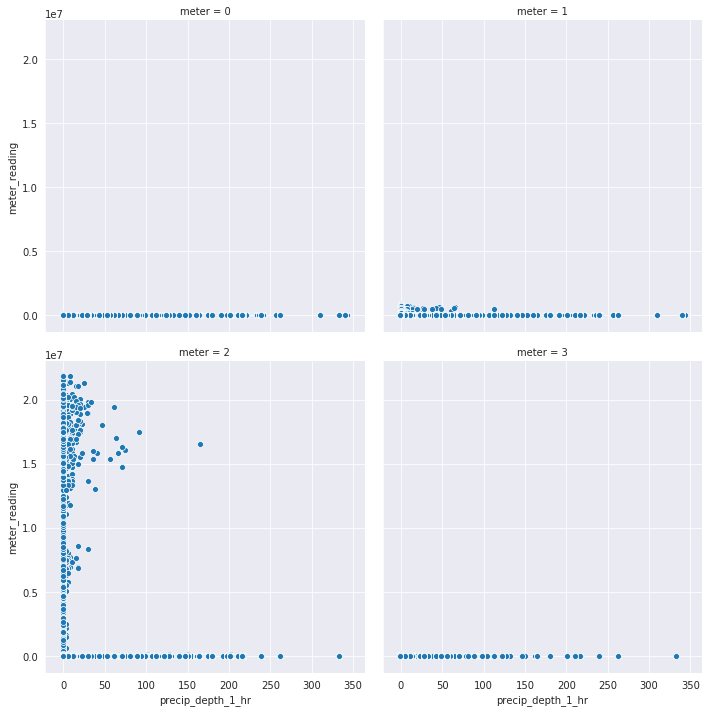

In [24]:
sns.relplot(x='precip_depth_1_hr', y="meter_reading", col="meter", col_wrap=2, data=all_train_data)
gc.collect()

16630

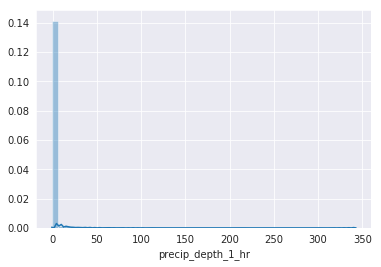

In [25]:
sns.distplot(all_train_data[np.isfinite(all_train_data.precip_depth_1_hr)]['precip_depth_1_hr'])
gc.collect()

354

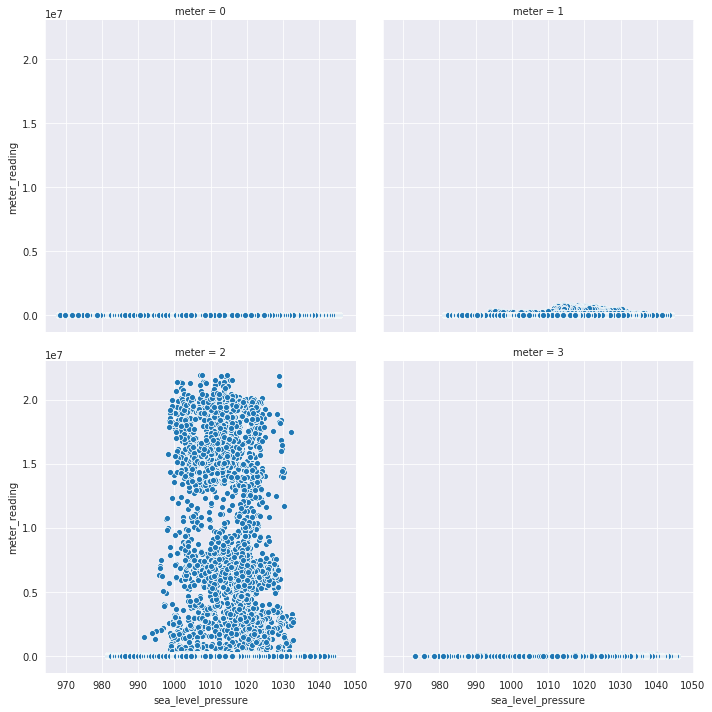

In [26]:
sns.relplot(x='sea_level_pressure', y="meter_reading", col="meter", col_wrap=2, data=all_train_data)
gc.collect()

16970

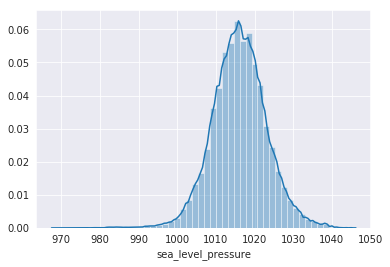

In [27]:
sns.distplot(all_train_data[np.isfinite(all_train_data.sea_level_pressure)]['sea_level_pressure'])
gc.collect()

539

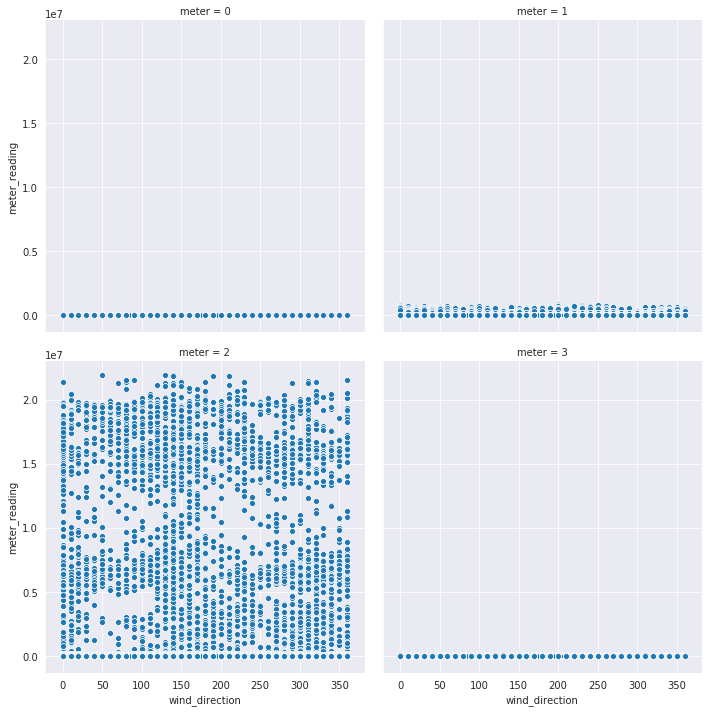

In [28]:
sns.relplot(x='wind_direction', y="meter_reading", col="meter", col_wrap=2, data=all_train_data)
gc.collect()

16630

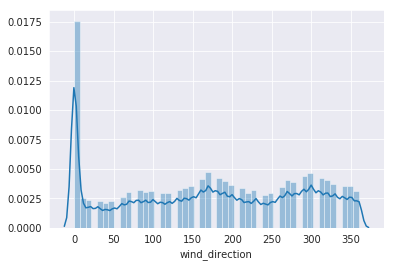

In [29]:
sns.distplot(all_train_data[np.isfinite(all_train_data.wind_direction)]['wind_direction'])
gc.collect()

539

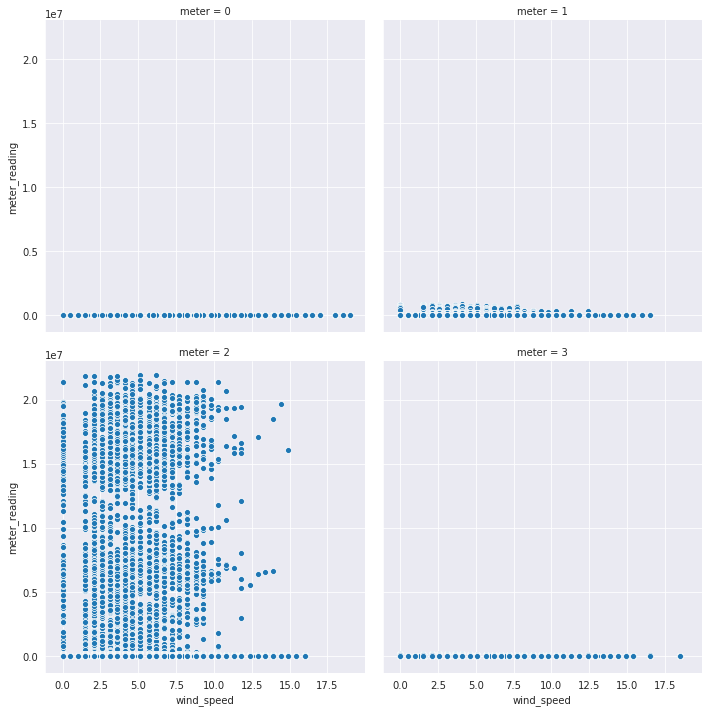

In [30]:
sns.relplot(x='wind_speed', y="meter_reading", col="meter", col_wrap=2, data=all_train_data)
gc.collect()

16630

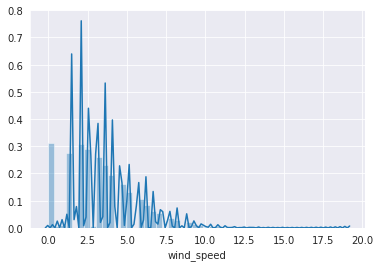

In [31]:
sns.distplot(all_train_data[np.isfinite(all_train_data.wind_speed)]['wind_speed'])
gc.collect()

### 类别字段相关性、分布情况分析

{0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

In [32]:
categories_feature = ['building_id','site_id','year_built','meter','primary_use']

53576

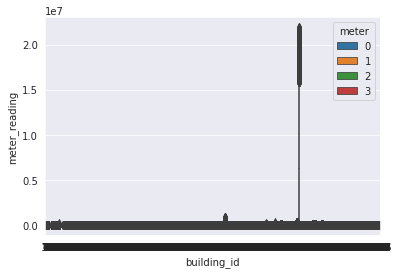

In [33]:
sns.boxplot(x="building_id", y="meter_reading", hue="meter", data=all_train_data)
gc.collect()

51363

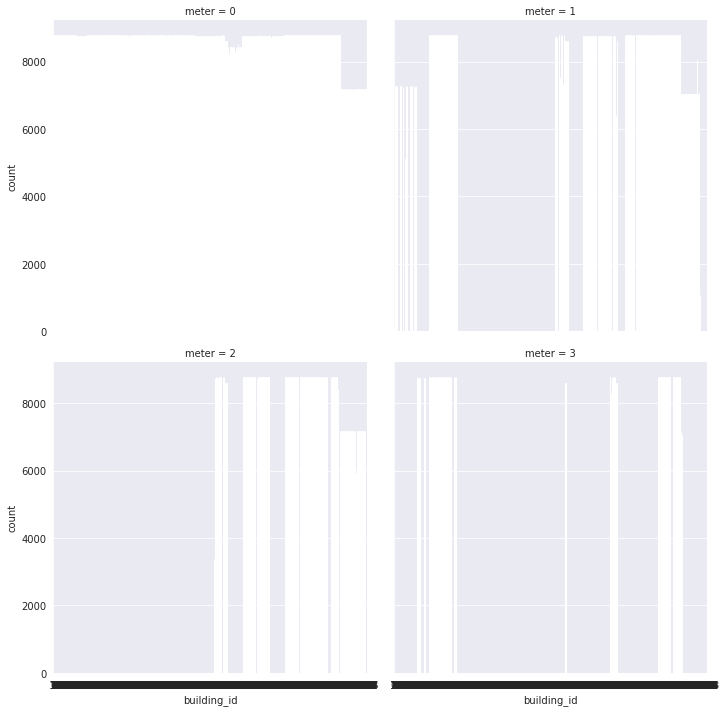

In [34]:
sns.catplot(x="building_id", col="meter", col_wrap=2, data=all_train_data, kind="count")
gc.collect()

407

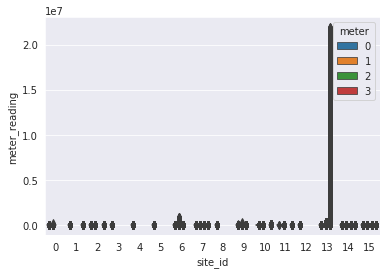

In [35]:
sns.boxplot(x="site_id", y="meter_reading", hue="meter", data=all_train_data)
gc.collect()

532

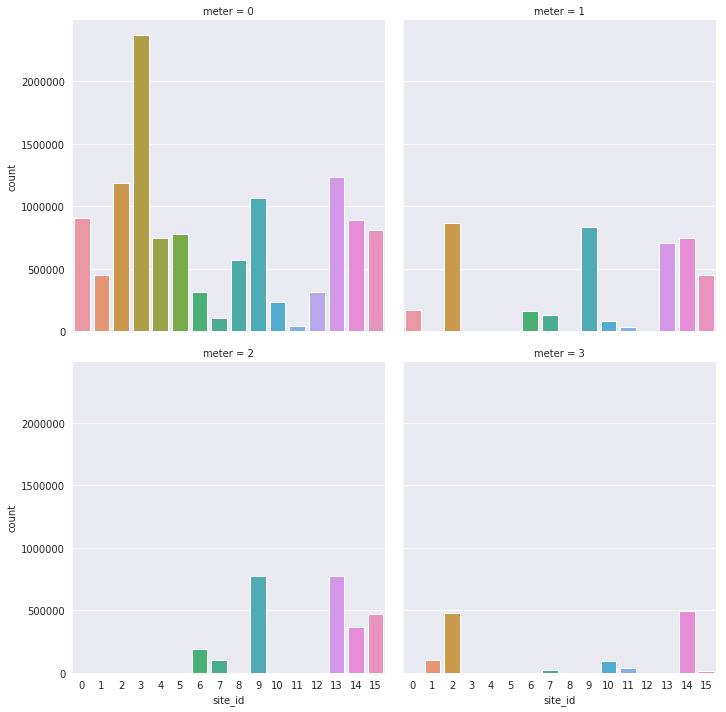

In [36]:
sns.catplot(x="site_id", col="meter", col_wrap=2, data=all_train_data, kind="count")
gc.collect()

4255

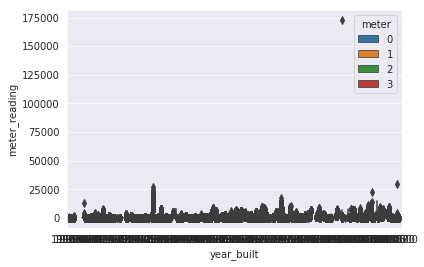

In [37]:
sns.boxplot(x="year_built", y="meter_reading", hue="meter", data=all_train_data)
gc.collect()

2271

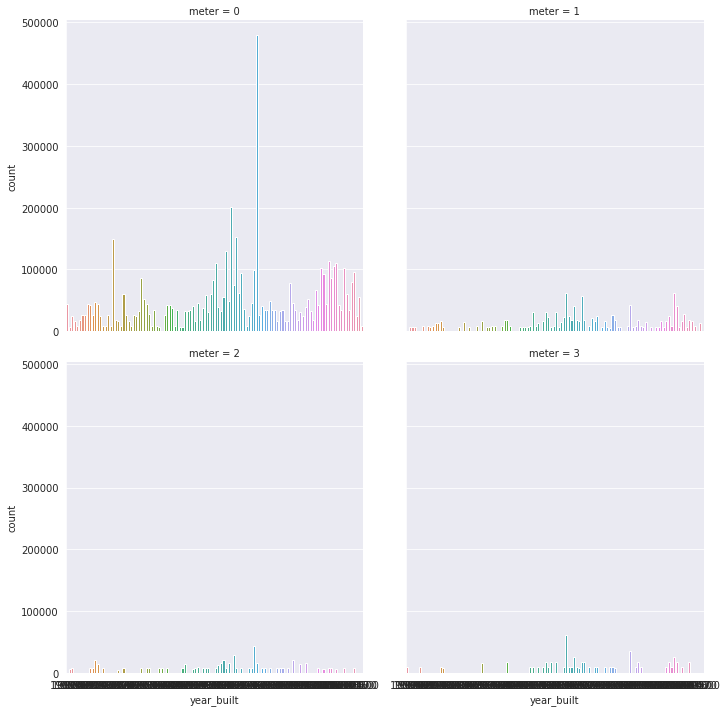

In [38]:
sns.catplot(x="year_built", col="meter", col_wrap=2, data=all_train_data, kind="count")
gc.collect()

109534

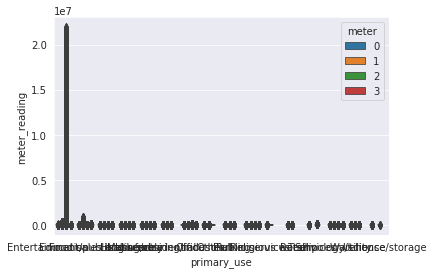

In [39]:
sns.boxplot(x="primary_use", y="meter_reading", hue="meter", data=all_train_data)
gc.collect()

532

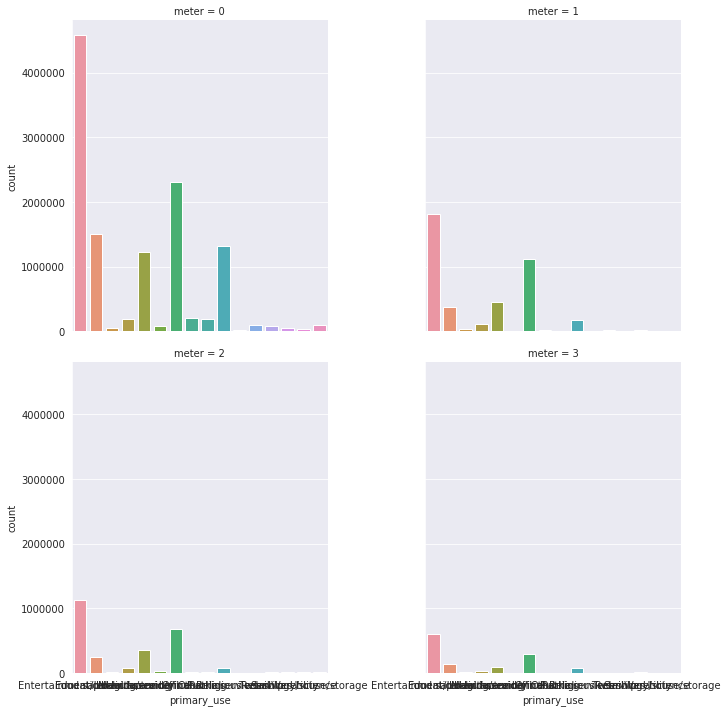

In [40]:
sns.catplot(x="primary_use", col="meter", col_wrap=2, data=all_train_data, kind="count")
gc.collect()